## Analyse and Classify Domains

In this notebook, we will analyse and classify the domains retrieved from the preprocessing steps.

We now have in our hands a list of domains for each video and a sponsor score determining if the video description contains a sponsorship-related theme. We do the following:

1. Firstly, we perform an overall analysis of the domains and find their average sponsor score.

2. In a second step, we take the most popular domains occurring in at least $10'000$ videos. We classify them into categories and determine if they are sponsor-related or not. In this step, the average sponsor score might be a good indicator.

3. Analysis on classified domains.

In [1]:
import findspark
findspark.init()

import numpy as np
import seaborn as sns

from pyspark.sql.functions import explode, udf, count, collect_list
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g')
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution
spark = SparkSession(sc)

plt.style.use('ggplot')

In [2]:
PATH_METADATAS_DOMAINS_SRC = '../data/generated/yt_metadata_en_domains.parquet'
PATH_METADATAS_SPONSOR_SCORES_SRC = '../data/generated/yt_metadata_en_sponsor_scores.parquet'

In [3]:
metadatas_domains = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC)
metadatas_sponsor_scores = spark.read.parquet(PATH_METADATAS_SPONSOR_SCORES_SRC)
metadatas = metadatas_domains.join(metadatas_sponsor_scores, on='display_id', how='left')

In [ ]:
assert metadatas.count() == metadatas_domains.count()

In [4]:
metadatas.dtypes

[('display_id', 'string'),
 ('categories', 'string'),
 ('channel_id', 'string'),
 ('dislike_count', 'int'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('domains', 'array<string>'),
 ('domains_count', 'int'),
 ('has_domains', 'string'),
 ('sponsor_score', 'int')]

In [4]:
metadatas.select('display_id', 'domains', 'sponsor_score').show(5)

+-----------+--------------------+-------------+
| display_id|             domains|sponsor_score|
+-----------+--------------------+-------------+
|82fVA65rbts|           [radi.al]|            2|
|Hpxh4XBQBEk|[whatcar.com, sma...|            9|
|K308-reAiTk|[linyibrickmachin...|            2|
|Qit2N489qqk|[whatcar.com, the...|            9|
|VFwTdmiqlmM|[iteachstamping.c...|            1|
+-----------+--------------------+-------------+
only showing top 5 rows



In [4]:
domains_count = metadatas \
    .select(explode('domains').alias('domain')) \
    .groupBy('domain') \
    .count() \
    .orderBy('count', ascending=False)

In [5]:
total_counts = domains_count.select('count').collect()
total_counts = [c[0] for c in total_counts]

print(f"There are a total of {len(total_counts)} domains.")

There are a total of 1077304 domains.


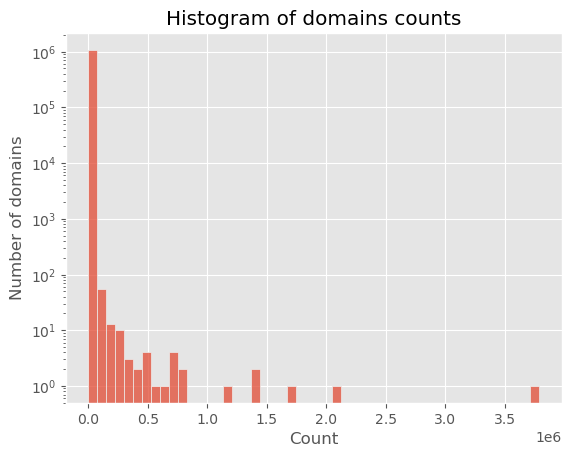

In [6]:
sns.histplot(total_counts, bins=50)
plt.yscale('log')
plt.title('Histogram of domains counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

In [7]:
def find_median(values_list):
    try:
        median = np.median(values_list)
        return round(float(median), 2)
    except Exception:
        return None

In [8]:
MIN_DOMAIN_COUNT = 10_000

median_udf = udf(find_median, FloatType())

domains_top_count = metadatas \
    .select(explode('domains').alias('domain'), 'sponsor_score') \
    .groupBy('domain') \
    .agg(count('domain').alias('count'), collect_list('sponsor_score').alias('sponsor_scores')) \
    .filter(f'count >= {MIN_DOMAIN_COUNT}') \
    .withColumn('median_sponsor_score', median_udf('sponsor_scores')) \
    .drop('sponsor_scores') \
    .orderBy('count', ascending=False)

In [11]:
domains_top_count.show(10)

+-------------------+-------+--------------------+
|             domain|  count|median_sponsor_score|
+-------------------+-------+--------------------+
|    plus.google.com|3786647|                 3.0|
|    play.google.com|2093786|                 4.0|
|   itunes.apple.com|1724603|                 3.0|
|             bit.ly|1408414|                 3.0|
|        tinyurl.com|1380122|                 4.0|
|          rstyle.me|1175073|                11.0|
| steamcommunity.com| 824573|                 3.0|
|creativecommons.org| 767740|                 4.0|
|        smarturl.it| 750397|                 3.0|
|              po.st| 739548|                 4.0|
+-------------------+-------+--------------------+
only showing top 10 rows



In [9]:
top_counts = domains_top_count.select('count').collect()
top_counts = [c[0] for c in top_counts]

print(f"There are a total of {len(top_counts)} domains with at least {MIN_DOMAIN_COUNT} counts.")

There are a total of 1000 domains with at least 10000 counts.


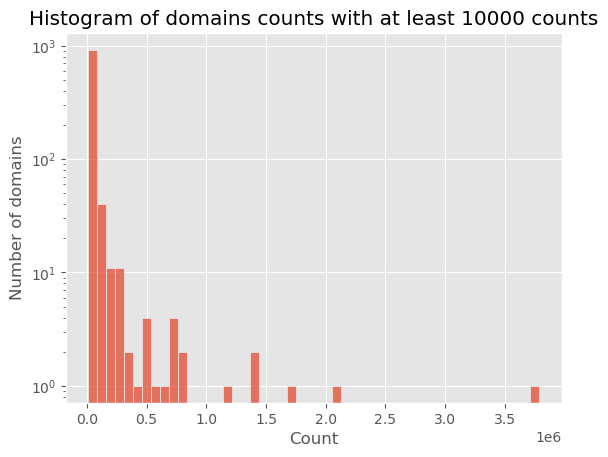

In [10]:
sns.histplot(top_counts, bins=50)
plt.yscale('log')
plt.title(f'Histogram of domains counts with at least {MIN_DOMAIN_COUNT} counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

Both distributions are **heavy-tailed to the right**. Indeed, there are many domains that appear in some videos only and a small subset of domains seem to prevail in many videos. This is a typical feature of a **power-law distributions**. The **log-log plot** of the distribution of the number of videos per domain is shown below.

Taking only domains that appear in at least $10'000$ videos does not change much the distribution as it might still be considered as a small amount of occurence for a domain. Nevertheless, we end up with only $1'000$ distinct domains to take into account, which is a reasonable amount of data to work with.

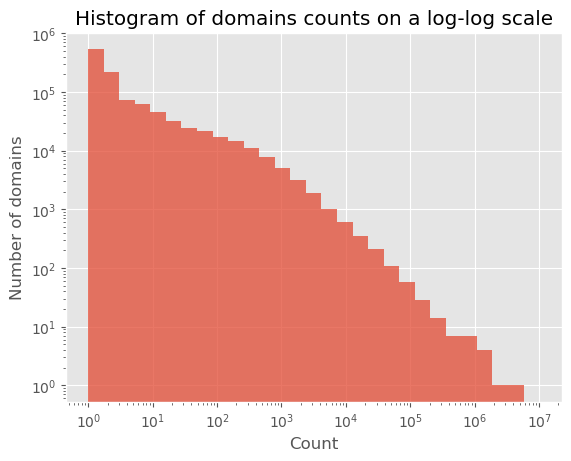

In [11]:
sns.histplot(total_counts, bins=np.logspace(0, 7, 30))
plt.yscale('log')
plt.xscale('log')
plt.title('Histogram of domains counts on a log-log scale')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

The distribution of the number of videos per domain follows approximately a straight line in the log-log plot above. It seems to follow a **power-law distribution**.

In [16]:
PATH_METADATAS_TOP_COUNTS_DST = '../data/generated/yt_metadata_en_domains_top_count.csv'

In [17]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_TOP_COUNTS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_TOP_COUNTS_DST -Recurse -Force" # Windows

In [18]:
domains_top_count.write.csv(PATH_METADATAS_TOP_COUNTS_DST)

### Classified Domains

We now take the most popular domains occurring in at least $10'000$ videos. We classify them into categories and determine if they are sponsor-related or not. In this step, the average sponsor score might help us to determine if a domain is sponsor-related or not. The classification lables that we came up with are the following:
- Agency: Agencies that aim to help Youtubers to develop, monetize their content.
- Application
- Book
- Beauty
- Crypto
- Donation
- Dating
- Education: Takes into account online courses.
- Entertainment
- Fashion
- Finance
- Food Drink
- Forum
- Government
- Media: Takes into account news, tv, radio.
- Medical
- Music
- OVP: Online video platform, users **can** upload them.
- Photo
- Real Estate
- Religion
- Science
- Service: Online services to help YouTubers such as video footages, music, stock footages.
- Sharing Service: Platform to share content (flickr, imgur, ...).
- Shop: Online shops that sell a high range of products
- Shorten: Shorten services
- Social Media
- Sport
- Streaming: Online video platform, users **cannot** upload them.
- Technology
- Travel
- Vehicle
- Video Game
- YCW: YouTube channel website: websites of channel videos

In [12]:
PATH_METADATAS_TOP_COUNTS_SRC = '../data/domains_classification.csv'

In [13]:
schema = StructType([
    StructField("domain",               StringType(),  True),
    StructField("count",                IntegerType(), True),
    StructField("median_sponsor_score", FloatType(), True),
    StructField("is_sponsored",         IntegerType(), True),
    StructField("domain_category",      StringType(),  True),
])

domains_top_classified = spark.read.csv(PATH_METADATAS_TOP_COUNTS_SRC, header=True, schema=schema)
domains_top_classified = domains_top_classified.filter('domain_category is not null')

# change median sposor score to int
domains_top_classified = domains_top_classified \
    .withColumn("median_sponsor_score", domains_top_classified.median_sponsor_score.cast(IntegerType())) \
    .withColumn("is_sponsored", domains_top_classified.is_sponsored.cast(BooleanType()))

In [14]:
domains_top_classified.show()

+--------------------+-------+--------------------+------------+---------------+
|              domain|  count|median_sponsor_score|is_sponsored|domain_category|
+--------------------+-------+--------------------+------------+---------------+
|     plus.google.com|3786647|                   3|       false|   Social Media|
|     play.google.com|2093786|                   4|        true|    Application|
|    itunes.apple.com|1724603|                   3|       false|          Music|
|              bit.ly|1408414|                   3|       false|        Shorten|
|         tinyurl.com|1380122|                   4|       false|        Shorten|
|           rstyle.me|1175073|                  11|        true|         Agency|
|  steamcommunity.com| 824573|                   3|       false|     Video Game|
| creativecommons.org| 767740|                   4|       false|      Education|
|         smarturl.it| 750397|                   3|       false|        Shorten|
|               po.st| 73954

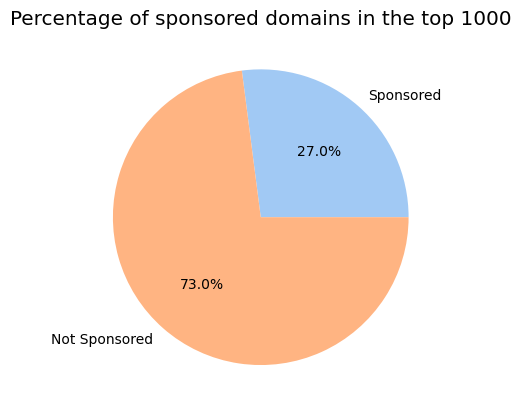

In [15]:
sp_domains_cnt = [row[1] for row in domains_top_classified.groupBy('is_sponsored').count().collect()]

colors = sns.color_palette('pastel')
plt.pie(sp_domains_cnt, labels=['Sponsored', 'Not Sponsored'], autopct='%1.1f%%', colors=colors)
plt.title('Percentage of sponsored domains in the top 1000')
plt.show()

In [16]:
sp_domains = domains_top_classified.filter(domains_top_classified.is_sponsored)
nsp_domains = domains_top_classified.filter(~domains_top_classified.is_sponsored)

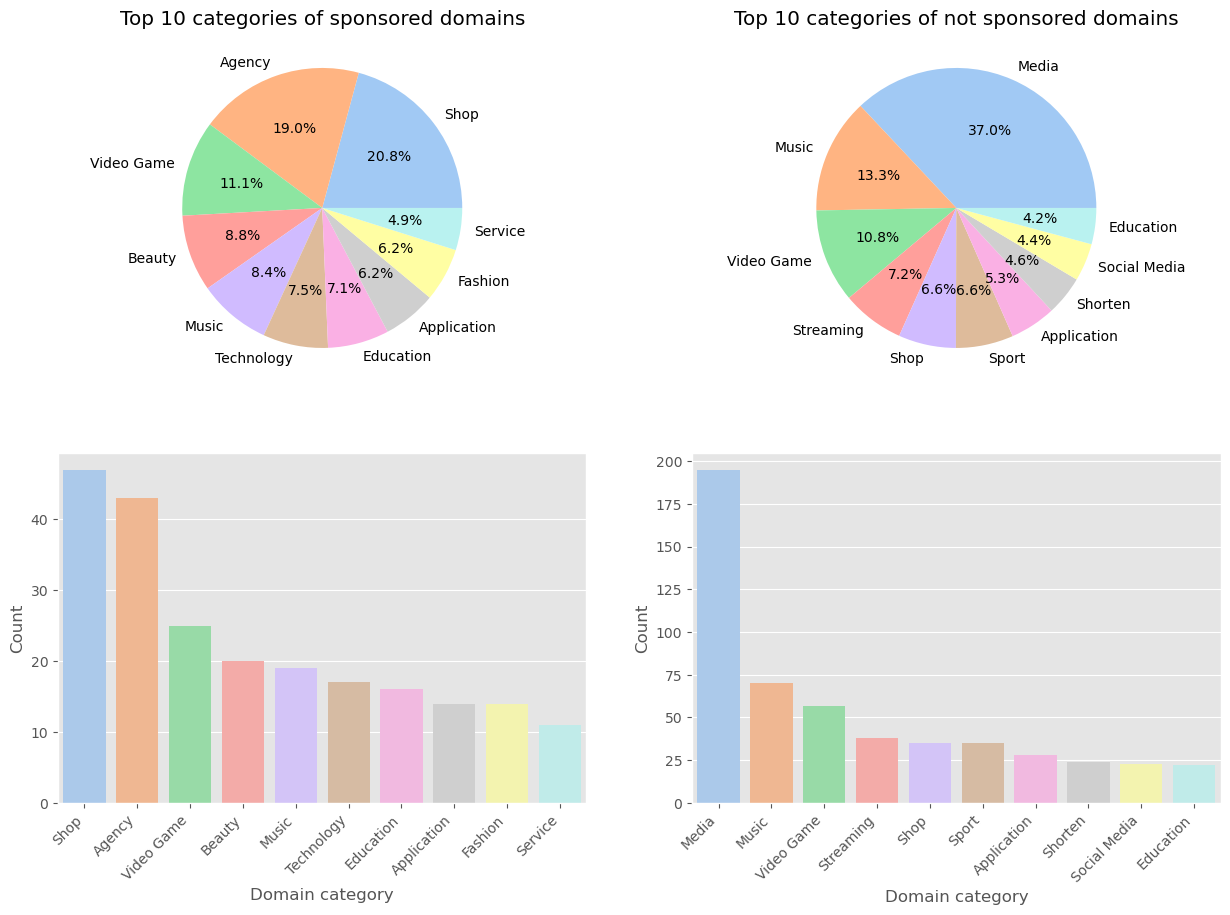

In [18]:
classified_sp_domains_cnt = [(row.domain_category, row[1]) for row in sp_domains.groupBy('domain_category').count().collect()]
classified_sp_domains_cnt = sorted(classified_sp_domains_cnt, key=lambda x: x[1], reverse=True)
classified_sp_domains_cnt = classified_sp_domains_cnt[:10]

classified_nsp_domains_cnt = [(row.domain_category, row[1]) for row in nsp_domains.groupBy('domain_category').count().collect()]
classified_nsp_domains_cnt = sorted(classified_nsp_domains_cnt, key=lambda x: x[1], reverse=True)
classified_nsp_domains_cnt = classified_nsp_domains_cnt[:10]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.pie(x=[x[1] for x in classified_sp_domains_cnt], labels=[x[0] for x in classified_sp_domains_cnt], autopct='%1.1f%%', colors=colors)
ax1.set_title('Top 10 categories of sponsored domains')

ax2.pie(x=[x[1] for x in classified_nsp_domains_cnt], labels=[x[0] for x in classified_nsp_domains_cnt], autopct='%1.1f%%', colors=colors)
ax2.set_title('Top 10 categories of not sponsored domains')

sns.barplot(x=[x[0] for x in classified_sp_domains_cnt], y=[x[1] for x in classified_sp_domains_cnt], ax=ax3, palette=colors)
ax3.set(xlabel='Domain category', ylabel='Count')
plt.setp(ax3.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.barplot(x=[x[0] for x in classified_nsp_domains_cnt], y=[x[1] for x in classified_nsp_domains_cnt], ax=ax4, palette=colors)
ax4.set(xlabel='Domain category', ylabel='Count')
plt.setp(ax4.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

Video game same place, agencies only sponsored which make sense, shop buy stuff.. media not really sponsored, more on youtube because it is a video platform to 'educate' people.